# Tax Smoothing

## Overview


This  is a sister lecture to our  lecture on {doc}`consumption-smoothing <cons_smooth>`.


By renaming variables, we  obtain  a  version of a model "tax-smoothing model" that  Robert Barro {cite}`Barro1979` used  to explain why governments sometimes choose not to balance their budgets every period but instead use issue debt to smooth tax rates over time.

The government chooses a tax collection path that minimizes the present value of its costs of raising revenue.


The government minimizes those costs by smoothing  tax collections  over time and by issuing government debt during temporary surges in government expenditures.


The present value of government expenditures is at the core of the tax-smoothing model,
so we'll again use formulas presented in {doc}`present value formulas<pv>`.

We'll again use the matrix multiplication and matrix inversion tools that we used in  {doc}`present value formulas <pv>`. 






## Analysis

As usual, we'll start by importing some Python modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

A government exists at times $t=0, 1, \ldots, S$ and  faces an exogenous stream of expenditures $\{G_t\}_{t=0}^S$.

It chooses  chooses a stream of tax collections $\{T_t\}_{t=0}^S$.

The model takes a government expenditure stream as an "exogenous" input that is somehow determined  outside the model.

The government faces a gross interest rate of $R >1$ that is constant over time.

The government can borrow or lend at interest rate $R$, subject to some limits on the amount of debt that it can issue  that we'll describe below.

Let

 * $S \geq 2$  be a positive integer that constitutes a time-horizon. 
 * $G = \{G_t\}_{t=0}^S$ be a sequence of government expenditures. 
 * $B = \{B_t\}_{t=0}^{S+1}$ be a sequence of government debt.  
 * $T = \{T_t\}_{t=0}^S$ be a sequence of tax collections. 
 * $R \geq 1$ be a fixed gross one period interest rate. 
 * $\beta \in (0,1)$ be a fixed discount factor.  
 * $B_0$ be a given initial level of government debt
 * $B_{S+1} \geq 0$  be a terminal condition. 

The sequence of government debt $B$ is to be determined by the model.

We require it to satisfy two **boundary conditions**:
   * it must equal an exogenous value $B_0$ at time $0$
   * it must equal or exceed an exogenous value $B_{S+1}$ at time $S+1$.

The **terminal condition** $B_{S+1} \geq 0$   requires that the government  not end up with negative assets.

(This no-Ponzi condition ensures that the government  ultimately pays off its debts -- it can't simply roll them over indefinitely.)

The government faces a sequence of budget constraints that constrain sequences $(G, T, B)$

$$
B_{t+1} = R (B_t + G_t - T_t), \quad t =0, 1, \ldots S
$$ (eq:B_t)

Equations {eq}`eq:B_t` constitute $S+1$ such budget constraints, one for each $t=0, 1, \ldots, S$.

Given a sequence $G$ of government expenditures, a large set of pairs $(B, T)$ of (government debt, tax collections) sequences satisfy the sequence of budget constraints {eq}`eq:B_t`.

The  model follows the following logical flow:

 * start with an exogenous government expenditure sequence $G$, an initial government debt $B_0$, and 
 a candidate tax collection path $T$.
 
 * use the system of equations {eq}`eq:B_t` for $t=0, \ldots, S$ to compute a path $B$ of government debt
 
 * verify that $B_{S+1}$ satisfies the terminal debt constraint $B_{S+1} \geq 0$. 
    
     * If it does, declare that the candidate path is **budget feasible**. 
 
     * if the candidate tax path is not budget feasible, propose a different tax path and start over
     
Below, we'll describe how to execute these steps using linear algebra -- matrix inversion and multiplication.

The above procedure seems like a sensible way to find "budget-feasible" tax paths $T$, i.e., paths that are consistent with the exogenous government expenditure stream $G$, the initial debt level $B_0$, and the terminal debt level $B_{S+1}$.

In general, there are **many** budget feasible tax paths $T$.

Among all budget-feasible tax paths, which one should a government choose?

To answer this question, we assess  alternative budget feasible tax paths $T$ using the following cost functional:

```{math}
:label: cost

L = - \sum_{t=0}^S \beta^t (g_1 T_t - \frac{g_2}{2} T_t^2 )
```

where $g_1 > 0, g_2 > 0$.  


This is called the "present value of revenue-raising costs" in {cite}`Barro1979`.

The quadratic term $-\frac{g_2}{2} T_t^2$ captures increasing marginal costs of taxation, implying that tax distortions rise more than proportionally with tax rates. 

This creates an incentive for tax smoothing.

Indeed, we shall see that when $\beta R = 1$, criterion {eq}`cost` leads to smoother tax paths.

By **smoother** we mean tax rates that are as close as possible to being constant over time.  

The preference for smooth tax paths that is built into the model gives it the name "tax-smoothing model".

Or equivalently, we can transform this into the same problem as in the {doc}`consumption-smoothing <cons_smooth>` lecture by maximizing the welfare criterion:

```{math}
:label: welfare_tax

W = \sum_{t=0}^S \beta^t (g_1 T_t - \frac{g_2}{2} T_t^2 )
```

Let's dive in and do some calculations that will help us understand how the model works. 

Here we use default parameters $R = 1.05$, $g_1 = 1$, $g_2 = 1/2$, and $S = 65$. 

We create a Python ``namedtuple`` to store these parameters with default values.

In [2]:
TaxSmoothing = namedtuple("TaxSmoothing", 
                        ["R", "g1", "g2", "β_seq", "S"])

def create_tax_smoothing_model(R=1.01, g1=1, g2=1/2, S=65):
    """
    Creates an instance of the tax smoothing model.
    """
    β = 1/R
    β_seq = np.array([β**i for i in range(S+1)])

    return TaxSmoothing(R, g1, g2, β_seq, S)

## Barro tax-smoothing model

A key object is the present value of government expenditures at time $0$:

$$
h_0 \equiv \sum_{t=0}^S R^{-t} G_t = \begin{bmatrix} 1 & R^{-1} & \cdots & R^{-S} \end{bmatrix}
\begin{bmatrix} G_0 \cr G_1  \cr \vdots \cr G_S \end{bmatrix}
$$

This sum represents the present value of all future government expenditures that must be financed.

Formally it resembles the present value calculations we saw in this QuantEcon lecture {doc}`present values <pv>`.

This present value calculation is crucial for determining the government's total financing needs.

By iterating on equation {eq}`eq:B_t` and imposing the terminal condition 

$$
B_{S+1} = 0,
$$

it is possible to convert a sequence of budget constraints {eq}`eq:B_t` into a single intertemporal constraint

$$ 
\sum_{t=0}^S R^{-t} T_t = B_0 + h_0. 
$$ (eq:budget_intertemp_tax)

Equation {eq}`eq:budget_intertemp_tax` says that the present value of tax collections must equal the sum of initial debt and the present value of government expenditures.

When $\beta R = 1$, it is optimal for a government to smooth taxes by setting 

$$ 
T_t = T_0 \quad t =0, 1, \ldots, S
$$

(Later we'll present a "variational argument" that shows that this constant path minimizes
criterion {eq}`cost` and maximizes {eq}`welfare_tax` when $\beta R =1$.)

In this case, we can use the intertemporal budget constraint to write

$$
T_t = T_0  = \left(\sum_{t=0}^S R^{-t}\right)^{-1} (B_0 + h_0), \quad t= 0, 1, \ldots, S.
$$ (eq:taxsmoothing)

Equation {eq}`eq:taxsmoothing` is the tax-smoothing model in a nutshell.

## Mechanics of tax-smoothing 

As promised, we'll provide step-by-step instructions on how to use linear algebra, readily implemented in Python, to compute all objects in play in the tax-smoothing model.

In the calculations below, we'll set default values of $R > 1$, e.g., $R = 1.05$, and $\beta = R^{-1}$.

### Step 1

For a $(S+1) \times 1$ vector $G$ of government expenditures, use matrix algebra to compute the present value

$$
h_0 = \sum_{t=0}^S R^{-t} G_t = \begin{bmatrix} 1 & R^{-1} & \cdots & R^{-S} \end{bmatrix}
\begin{bmatrix} G_0 \cr G_1  \cr \vdots \cr G_S \end{bmatrix}
$$

### Step 2

Compute a constant tax rate $T_0$:

$$
T_t = T_0 = \left( \frac{1 - R^{-1}}{1 - R^{-(S+1)}} \right) (B_0 + \sum_{t=0}^S R^{-t} G_t ) , \quad t = 0, 1, \ldots, S
$$

### Step 3

Use the system of equations {eq}`eq:B_t` for $t=0, \ldots, S$ to compute a path $B$ of government debt.

To do this, we transform  that system of difference equations into a single matrix equation as follows:

$$
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 & 0 \cr
-R & 1 & 0 & \cdots & 0 & 0 & 0 \cr
0 & -R & 1 & \cdots & 0 & 0 & 0 \cr
\vdots  &\vdots & \vdots & \cdots & \vdots & \vdots & \vdots \cr
0 & 0 & 0 & \cdots & -R & 1 & 0 \cr
0 & 0 & 0 & \cdots & 0 & -R & 1
\end{bmatrix} 
\begin{bmatrix} B_1 \cr B_2 \cr B_3 \cr \vdots \cr B_S \cr B_{S+1} 
\end{bmatrix}
= R 
\begin{bmatrix} G_0 + B_0 - T_0 \cr G_1 - T_0 \cr G_2 - T_0 \cr \vdots\cr G_{S-1} - T_0 \cr G_S - T_0
\end{bmatrix}
$$

Multiply both sides by the inverse of the matrix on the left side to compute

$$
 \begin{bmatrix} B_1 \cr B_2 \cr B_3 \cr \vdots \cr B_S \cr B_{S+1} \end{bmatrix}
$$

Because we have built into our calculations that the government must satisfy its intertemporal budget constraint and end with zero debt, just barely satisfying the
terminal condition that $B_{S+1} \geq 0$, it should turn out that 

$$
B_{S+1} = 0.
$$
 
Let's verify this with Python code.

First we implement the model with `compute_optimal`

In [3]:
def compute_optimal(model, B0, G_seq):

    R, S = model.R, model.S

    # present value of government expenditures
    h0 = model.β_seq @ G_seq     # since β = 1/R

    # optimal constant tax rate
    T0 = (1 - 1/R) / (1 - (1/R)**(S+1)) * (B0 + h0)
    T_seq = T0*np.ones(S+1)

    A = np.diag(-R*np.ones(S), k=-1) + np.eye(S+1)
    b = G_seq - T_seq
    b[0] = b[0] + B0
    B_seq = np.linalg.inv(A) @ b
    B_seq = np.concatenate([[B0], B_seq])

    return T_seq, B_seq, h0

We use an example where the government starts with initial debt $B_0>0$.

This represents the government's initial debt burden.

The government expenditure process $\{G_t\}_{t=0}^{S}$ is constant and positive up to $t=45$ and then drops to zero afterward.

The drop in government expenditures could reflect a change in spending requirements or demographic shifts.

In [4]:
# Initial debt
B0 = 2     # initial government debt

# Government expenditure process
G_seq = np.concatenate([np.ones(46), 4*np.ones(5), np.ones(15)])
tax_model = create_tax_smoothing_model()
T_seq, B_seq, h0 = compute_optimal(tax_model, B0, G_seq)

print('check B_S+1=0:', 
      np.abs(B_seq[-1] - 0) <= 1e-8)

check B_S+1=0: True


The graphs below show paths of government expenditures, tax collections, and government debt.

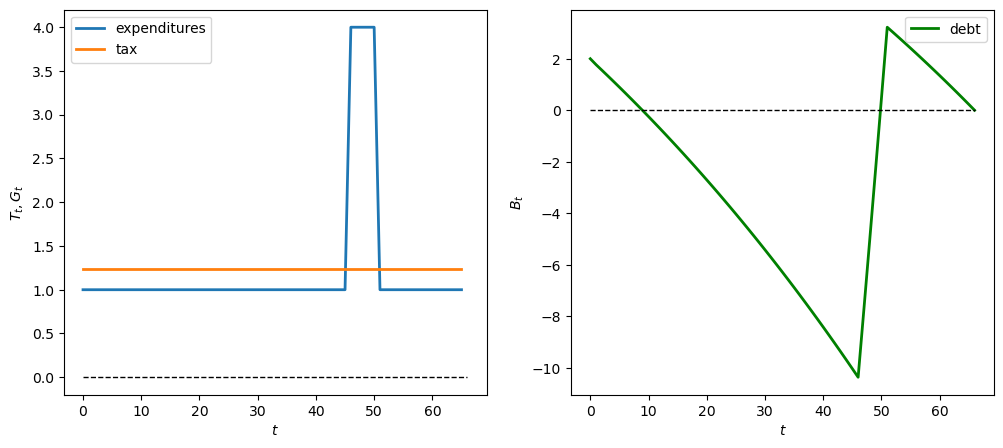

In [5]:
# Sequence length
S = tax_model.S

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].plot(range(S+1), G_seq, label='expenditures', lw=2)
axes[0].plot(range(S+1), T_seq, label='tax', lw=2)
axes[1].plot(range(S+2), B_seq, label='debt', color='green', lw=2)
axes[0].set_ylabel(r'$T_t,G_t$')
axes[1].set_ylabel(r'$B_t$')

for ax in axes:
    ax.plot(range(S+2), np.zeros(S+2), '--', lw=1, color='black')
    ax.legend()
    ax.set_xlabel(r'$t$')

plt.show()

Note that $B_{S+1} = 0$, as anticipated.

We can evaluate cost criterion {eq}`cost` which measures the total cost / welfare of taxation

In [6]:
def cost(model, T_seq):
    β_seq, g1, g2 = model.β_seq, model.g1, model.g2
    cost_seq = g1 * T_seq - g2/2 * T_seq**2
    return - β_seq @ cost_seq

print('Cost:', cost(tax_model, T_seq))

def welfare(model, T_seq):
    return - cost(model, T_seq)

print('Welfare:', welfare(tax_model, T_seq))

Cost: -41.46532630469102
Welfare: 41.46532630469102


### Experiments

In this section we describe how a tax sequence would optimally respond to different sequences of government expenditures.

First we create a function `plot_ts` that generates graphs for different instances of the tax-smoothing model `tax_model`.

This will help us avoid rewriting code to plot outcomes for different government expenditure sequences.

In [7]:
def plot_ts(model,    # tax-smoothing model      
            B0,       # initial government debt
            G_seq     # government expenditure process
           ):
    
    # Compute optimal tax path
    T_seq, B_seq, h0 = compute_optimal(model, B0, G_seq)
    
    # Sequence length
    S = tax_model.S
    
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    
    axes[0].plot(range(S+1), G_seq, label='expenditures', lw=2)
    axes[0].plot(range(S+1), T_seq, label='taxes', lw=2)
    axes[1].plot(range(S+2), B_seq, label='debt', color='green', lw=2)
    axes[0].set_ylabel(r'$T_t,G_t$')
    axes[1].set_ylabel(r'$B_t$')
    
    for ax in axes:
        ax.plot(range(S+2), np.zeros(S+2), '--', lw=1, color='black')
        ax.legend()
        ax.set_xlabel(r'$t$')
    
    
    plt.show()

In the experiments below, please study how tax and government debt sequences vary across different sequences for government expenditures.

#### Experiment 1: one-time spending shock

We first assume a one-time spending shock of $W_0$ in year 21 of the expenditure sequence $G$.  

We'll make $W_0$ big - positive to indicate a spending surge (like a war or disaster), and negative to indicate a spending cut.

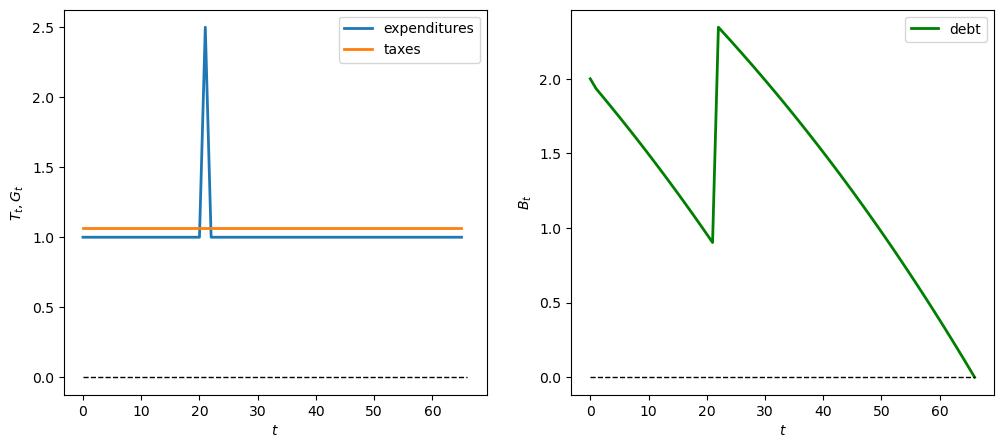

In [8]:
# Spending surge W_0 = 2.5
G_seq_pos = np.concatenate([np.ones(21), np.array([2.5]), 
np.ones(24), np.ones(20)])

plot_ts(tax_model, B0, G_seq_pos)

#### Experiment 2: permanent expenditure shift

Now we assume a permanent increase in government expenditures of $L$ in year 21 of the $G$-sequence.

Again we can study positive and negative cases

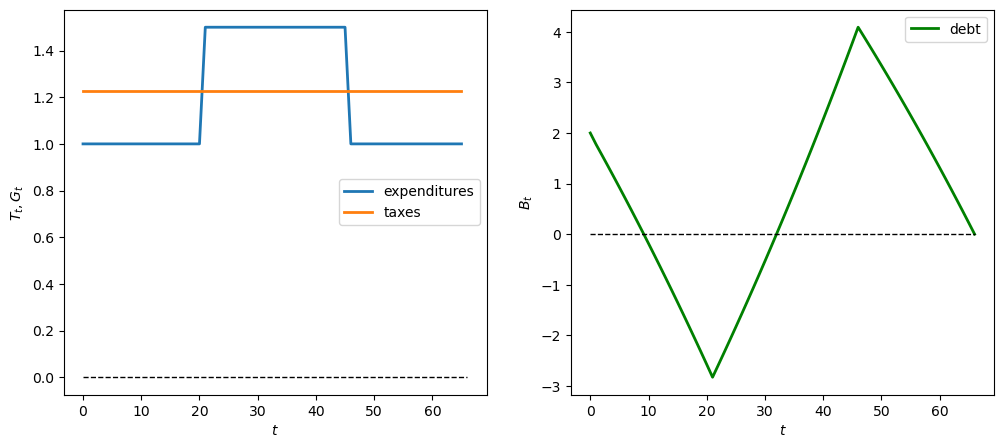

In [9]:
# Positive temporary expenditure shift L = 0.5 when t >= 21
G_seq_pos = np.concatenate(
    [np.ones(21), 1.5*np.ones(25), np.ones(20)])

plot_ts(tax_model, B0, G_seq_pos)

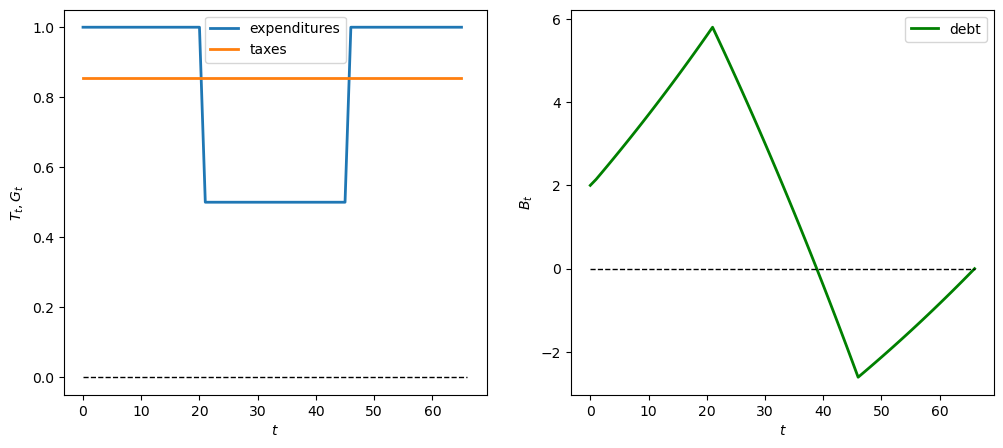

In [10]:
# Negative temporary expenditure shift L = -0.5 when t >= 21
G_seq_neg = np.concatenate(
    [np.ones(21), .5*np.ones(25), np.ones(20)])

plot_ts(tax_model, B0, G_seq_neg)

#### Experiment 3: delayed spending surge

Now we simulate a $G$ sequence in which government expenditures are zero for 46 years, and then rise to 1 for the last 20 years (perhaps due to demographic aging)

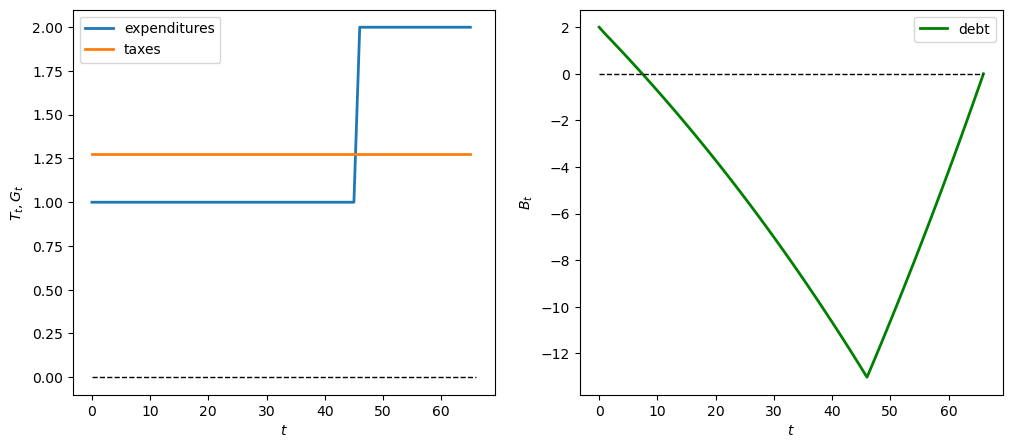

In [11]:
# Delayed spending
G_seq_late = np.concatenate(
    [np.ones(46), 2*np.ones(20)])

plot_ts(tax_model, B0, G_seq_late)

#### Experiment 4: growing expenditures

Now we simulate a geometric $G$ sequence in which government expenditures grow at rate $G_t = \lambda^t G_0$ in first 46 years.

We first experiment with $\lambda = 1.05$ (growing expenditures)

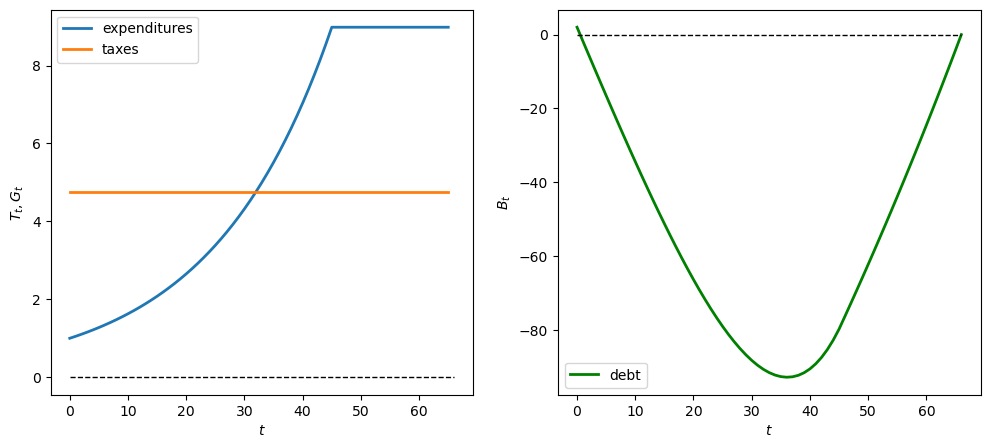

In [12]:
# Geometric growth parameters where λ = 1.05
λ = 1.05
G_0 = 1
t_max = 46

# Generate geometric G sequence
geo_seq = λ ** np.arange(t_max) * G_0 
G_seq_geo = np.concatenate(
            [geo_seq, np.max(geo_seq)*np.ones(20)])

plot_ts(tax_model, B0, G_seq_geo)

Now we show the behavior when $\lambda = 0.95$ (declining expenditures)

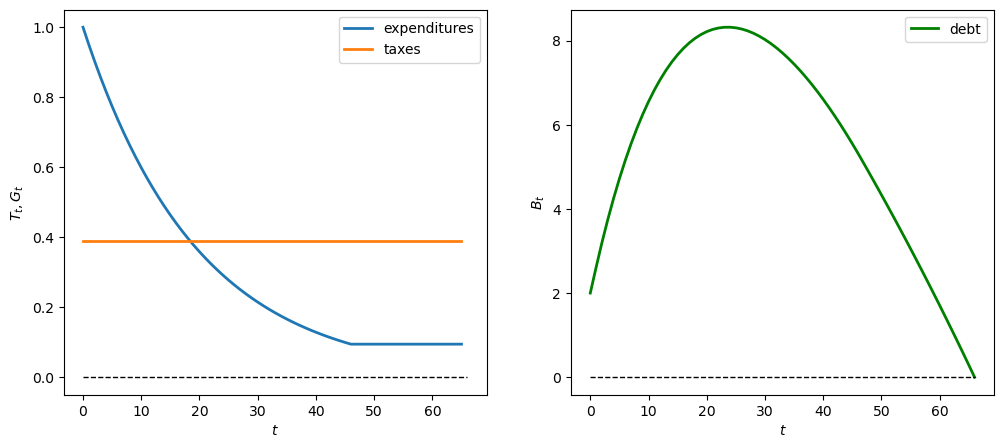

In [13]:
λ = 0.95
geo_seq = λ ** np.arange(t_max) * G_0 
G_seq_geo = np.concatenate(
            [geo_seq, λ ** t_max * np.ones(20)])

plot_ts(tax_model, B0, G_seq_geo)

What happens with oscillating expenditures

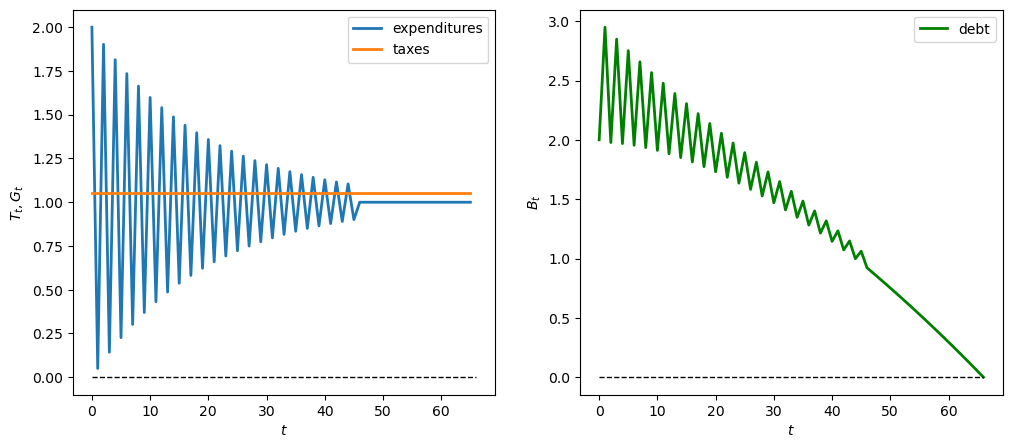

In [14]:
λ = -0.95
geo_seq = λ ** np.arange(t_max) * G_0 + 1
G_seq_geo = np.concatenate(
            [geo_seq, np.ones(20)])

plot_ts(tax_model, B0, G_seq_geo)

### Feasible Tax Variations

We promised to justify our claim that a constant tax rate $T_t = T_0$ for all $t$ is optimal.  

Let's do that now.

The approach we'll take is an elementary example of the "calculus of variations". 

Let's dive in and see what the key idea is.  

To explore what types of tax paths are cost-minimizing / welfare-improving, we shall create an **admissible tax path variation sequence** $\{v_t\}_{t=0}^S$
that satisfies

$$
\sum_{t=0}^S R^{-t} v_t = 0.
$$

This equation says that the **present value** of admissible tax path variations must be zero.

So once again, we encounter a formula for the present value:

   * we require that the present value of tax path variations be zero to maintain budget balance.

Here we'll restrict ourselves to a two-parameter class of admissible tax path variations of the form

$$
v_t = \xi_1 \phi^t - \xi_0.
$$

We say two and not three-parameter class because $\xi_0$ will be a function of $(\phi, \xi_1; R)$ that guarantees that the variation sequence is feasible. 

Let's compute that function.

We require

$$
\sum_{t=0}^S R^{-t}\left[ \xi_1 \phi^t - \xi_0 \right] = 0
$$

which implies that

$$
\xi_1 \sum_{t=0}^S \phi_t R^{-t} - \xi_0 \sum_{t=0}^S R^{-t} = 0
$$

which implies that

$$
\xi_1 \frac{1 - (\phi R^{-1})^{S+1}}{1 - \phi R^{-1}} - \xi_0 \frac{1 - R^{-(S+1)}}{1-R^{-1} } =0
$$

which implies that

$$
\xi_0 = \xi_0(\phi, \xi_1; R) = \xi_1 \left(\frac{1 - R^{-1}}{1 - R^{-(S+1)}}\right) \left(\frac{1 - (\phi R^{-1})^{S+1}}{1 - \phi R^{-1}}\right)
$$ 

This is our formula for $\xi_0$.  

**Key Idea:** if $T^o$ is a budget-feasible tax path, then so is $T^o + v$,
where $v$ is a budget-feasible variation.

Given $R$, we thus have a two parameter class of budget feasible variations $v$ that we can use
to compute alternative tax paths, then evaluate their welfare costs.

Now let's compute and plot tax path variations

In [15]:
def compute_variation(model, ξ1, ϕ, B0, G_seq, verbose=1):
    R, S, β_seq = model.R, model.S, model.β_seq

    ξ0 = ξ1*((1 - 1/R) / (1 - (1/R)**(S+1))) * ((1 - (ϕ/R)**(S+1)) / (1 - ϕ/R))
    v_seq = np.array([(ξ1*ϕ**t - ξ0) for t in range(S+1)])
    
    if verbose == 1:
        print('check feasible:', np.isclose(β_seq @ v_seq, 0))     

    T_opt, _, _ = compute_optimal(model, B0, G_seq)
    Tvar_seq = T_opt + v_seq

    return Tvar_seq

We visualize variations for $\xi_1 \in \{.01, .05\}$ and $\phi \in \{.95, 1.02\}$

variation 0: ξ1=0.01, ϕ=0.95
check feasible: True
welfare=41.46523217108914
welfare < optimal: True
----------------------------------------------------------------
variation 1: ξ1=0.01, ϕ=1.02
check feasible: True
welfare=41.46467728803246
welfare < optimal: True
----------------------------------------------------------------
variation 2: ξ1=0.05, ϕ=0.95
check feasible: True
welfare=41.46297296464396
welfare < optimal: True
----------------------------------------------------------------
variation 3: ξ1=0.05, ϕ=1.02
check feasible: True
welfare=41.44910088822694
welfare < optimal: True
----------------------------------------------------------------


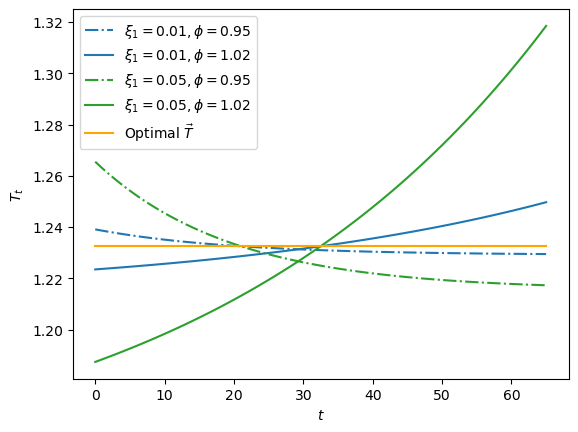

In [16]:
fig, ax = plt.subplots()
ξ1s = [.01, .05]
ϕs= [.95, 1.02]
colors = {.01: 'tab:blue', .05: 'tab:green'}
params = np.array(np.meshgrid(ξ1s, ϕs)).T.reshape(-1, 2)
wel_opt = welfare(tax_model, T_seq)

for i, param in enumerate(params):
    ξ1, ϕ = param
    print(f'variation {i}: ξ1={ξ1}, ϕ={ϕ}')

    Tvar_seq = compute_variation(model=tax_model, 
                                 ξ1=ξ1, ϕ=ϕ, B0=B0, 
                                 G_seq=G_seq)
    print(f'welfare={welfare(tax_model, Tvar_seq)}')
    print(f'welfare < optimal: {welfare(tax_model, Tvar_seq) < wel_opt}')
    print('-'*64)

    if i % 2 == 0:
        ls = '-.'
    else: 
        ls = '-'  
    ax.plot(range(S+1), Tvar_seq, ls=ls, 
            color=colors[ξ1], 
            label=fr'$\xi_1 = {ξ1}, \phi = {ϕ}$')

plt.plot(range(S+1), T_seq, 
         color='orange', label=r'Optimal $\vec{T}$ ')

plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$T_t$')
plt.show()

We can even use the Python `np.gradient` command to compute derivatives of cost with respect to our two parameters.  

We are teaching the key idea beneath the **calculus of variations**.
First, we define the cost with respect to $\xi_1$ and $\phi$

In [17]:
def cost_rel(ξ1, ϕ):
    """
    Compute cost of variation sequence 
    for given ϕ, ξ1 with a tax-smoothing model
    """
    
    Tvar_seq = compute_variation(tax_model, ξ1=ξ1, 
                                 ϕ=ϕ, B0=B0, 
                                 G_seq=G_seq, 
                                 verbose=0)
    return cost(tax_model, Tvar_seq)

# Vectorize the function to allow array input
cost_vec = np.vectorize(cost_rel)

Then we can visualize the relationship between cost and $\xi_1$ and compute its derivatives

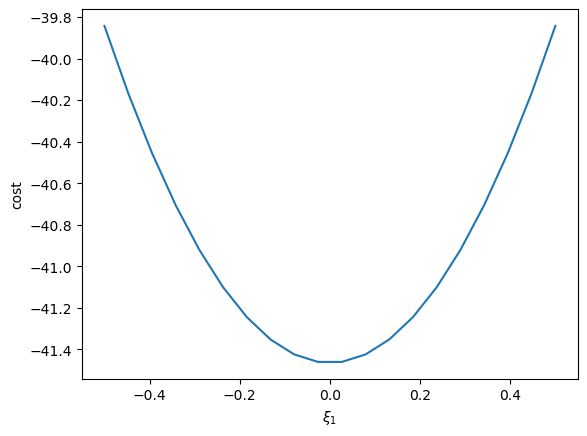

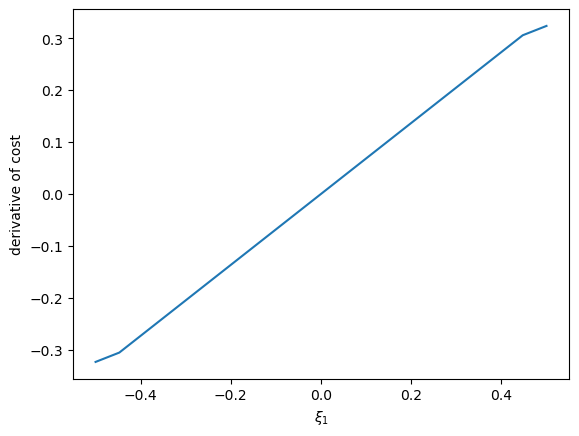

In [18]:
ξ1_arr = np.linspace(-0.5, 0.5, 20)

plt.plot(ξ1_arr, cost_vec(ξ1_arr, 1.02))
plt.ylabel('cost')
plt.xlabel(r'$\xi_1$')
plt.show()

cost_grad = cost_vec(ξ1_arr, 1.02)
cost_grad = np.gradient(cost_grad)
plt.plot(ξ1_arr, cost_grad)
plt.ylabel('derivative of cost')
plt.xlabel(r'$\xi_1$')
plt.show()

The same can be done on $\phi$

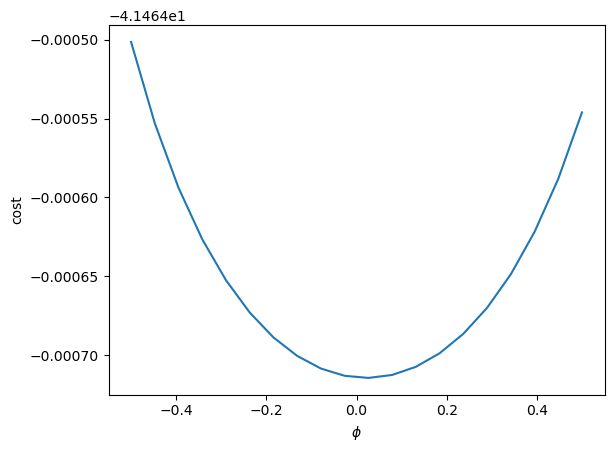

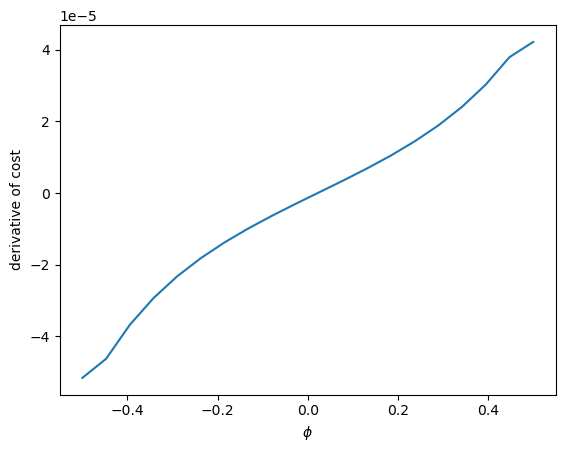

In [19]:
ϕ_arr = np.linspace(-0.5, 0.5, 20)

plt.plot(ξ1_arr, cost_vec(0.05, ϕ_arr))
plt.ylabel('cost')
plt.xlabel(r'$\phi$')
plt.show()

cost_grad = cost_vec(0.05, ϕ_arr)
cost_grad = np.gradient(cost_grad)
plt.plot(ξ1_arr, cost_grad)
plt.ylabel('derivative of cost')
plt.xlabel(r'$\phi$')
plt.show()